# Week 1 Pair Scan Workflow
This notebook walks through the full Track A analytics flow: load the configured ETF universe, compute correlation diagnostics, score candidate pairs (Engle–Granger), and persist artifacts (CSV/figures) for advisor reporting.

In [ ]:
from pathlib import Path
import sys

project_root = Path.cwd()
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent

src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

In [ ]:
import importlib
import inspect
from dataclasses import replace

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import pairs_trading_etf.analysis.correlation as correlation_module
import pairs_trading_etf.visualization.plots as plots_module
from pairs_trading_etf.analysis.correlation import (
    attach_sector_labels,
    compute_return_correlations,
    find_high_corr_pairs,
    summarise_pairs_by_bucket,
)
from pairs_trading_etf.visualization.plots import (
    plot_corr_vs_pvalue,
    plot_correlation_clustermap,
    plot_correlation_heatmap,
    plot_pair_bucket_boxplot,
    plot_pair_bucket_counts,
)
from pairs_trading_etf.data.loader import build_price_frame
from pairs_trading_etf.data.universe import load_configured_universe
from pairs_trading_etf.pipelines.pair_scan import PairScanConfig, run_pair_scan
from pairs_trading_etf.utils.config import load_yaml_config

correlation_module = importlib.reload(correlation_module)
plots_module = importlib.reload(plots_module)

sns.set_theme(style="white", context="talk")

CONFIG_PATH = project_root / "configs" / "data.yaml"
PRICE_PATH = project_root / "data" / "raw" / "etf_prices.csv"
METADATA_PATH = project_root / "configs" / "etf_metadata.yaml"
RESULTS_PATH = project_root / "results" / "week1_pair_scores.csv"
FIGURES_DIR = project_root / "results" / "figures" / "week1"
JOHANSEN_PATH = project_root / "results" / "week1_johansen_trace.csv"
HEATMAP_PATH = FIGURES_DIR / "week1_corr_heatmap.png"
CLUSTER_PATH = FIGURES_DIR / "week1_corr_clustermap.png"
PAIR_COUNTS_PATH = FIGURES_DIR / "week1_pair_bucket_counts.png"
PAIR_BOX_PATH = FIGURES_DIR / "week1_pair_corr_box.png"
SCATTER_PATH = FIGURES_DIR / "week1_corr_vs_pvalue.png"
HIGH_CORR_PATH = project_root / "results" / "week1_high_corr_pairs.csv"

CONFIG_PATH, PRICE_PATH, METADATA_PATH, RESULTS_PATH, FIGURES_DIR, JOHANSEN_PATH

(WindowsPath('i:/Winter-Break-Research/configs/data.yaml'),
 WindowsPath('i:/Winter-Break-Research/data/raw/etf_prices.csv'),
 WindowsPath('i:/Winter-Break-Research/configs/etf_metadata.yaml'),
 WindowsPath('i:/Winter-Break-Research/results/week1_pair_scores.csv'),
 WindowsPath('i:/Winter-Break-Research/results/figures/week1'),
 WindowsPath('i:/Winter-Break-Research/results/week1_johansen_trace.csv'))

In [22]:
config = load_yaml_config(CONFIG_PATH)
pair_defaults = config.get("pair_scan", {})

# Quick toggles: set either flag to override the YAML values without editing the file
FORCE_FULL_UNIVERSE = pair_defaults.get("force_full_universe", False)
FORCE_CROSS_SECTOR = pair_defaults.get("force_cross_sector", True)

LIST_OVERRIDE = pair_defaults.get("list_name")
if pair_defaults.get("use_full_universe") or FORCE_FULL_UNIVERSE:
    LIST_OVERRIDE = None

universe_cfg = config.get("universe", {})
universe_lists = universe_cfg.get("lists") or {}
TOTAL_DEFINED_TICKERS = len(universe_cfg.get("etfs", []))

if isinstance(LIST_OVERRIDE, str) and LIST_OVERRIDE.lower() in {"all", "full", "extended_all"}:
    LIST_OVERRIDE = None

resolved_label = (
    f"list '{LIST_OVERRIDE}'"
    if LIST_OVERRIDE
    else f"full `universe.etfs` roster ({TOTAL_DEFINED_TICKERS} tickers)"
 )
print(f"Resolved pair-scan list target: {resolved_label}")
if LIST_OVERRIDE and LIST_OVERRIDE in universe_lists:
    list_len = len(universe_lists[LIST_OVERRIDE].get("tickers", []))
    if TOTAL_DEFINED_TICKERS and list_len < TOTAL_DEFINED_TICKERS:
        print(
            f"Note: list '{LIST_OVERRIDE}' uses {list_len} of {TOTAL_DEFINED_TICKERS} tickers defined in universe.etfs.",
        )

ALLOW_CROSS_SECTOR = pair_defaults.get("allow_cross_sector", True)
if FORCE_CROSS_SECTOR:
    ALLOW_CROSS_SECTOR = True
print(f"Cross-sector pairs allowed? {ALLOW_CROSS_SECTOR} (force flag={FORCE_CROSS_SECTOR})")

print("Loaded pair scan defaults:")
pair_defaults

Resolved pair-scan list target: full `universe.etfs` roster (28 tickers)
Cross-sector pairs allowed? True (force flag=True)
Loaded pair scan defaults:


{'list_name': 'core_sectors',
 'use_full_universe': True,
 'allow_cross_sector': True,
 'lookback_days': 252,
 'min_obs': 180,
 'min_corr': 0.85,
 'max_pairs': 75,
 'engle_granger_maxlag': 1,
 'return_method': 'log'}

In [23]:
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.parent.mkdir(parents=True, exist_ok=True)
print(f"Artifacts will be written to {RESULTS_PATH.parent}")

Artifacts will be written to i:\Winter-Break-Research\results


In [24]:
universe = load_configured_universe(
    CONFIG_PATH,
    list_name=LIST_OVERRIDE,
    metadata_path=METADATA_PATH,
 )
list_label = LIST_OVERRIDE or "universe.etfs"
print(f"Universe '{universe.name}' ({list_label}) with {len(universe.tickers)} tickers")
if TOTAL_DEFINED_TICKERS and len(universe.tickers) < TOTAL_DEFINED_TICKERS and LIST_OVERRIDE:
    print(
        f"Reminder: {len(universe.tickers)} tickers selected while {TOTAL_DEFINED_TICKERS} are available in universe.etfs.",
    )

metadata_records = []
if universe.metadata:
    for ticker, meta in universe.metadata.items():
        metadata_records.append(
            {
                "ticker": ticker,
                "name": meta.name,
                "sector": meta.sector,
                "issuer": meta.issuer,
                "expense_ratio": meta.expense_ratio,
            }
        )

metadata_df = (
    pd.DataFrame(metadata_records).set_index("ticker").sort_index()
    if metadata_records
    else pd.DataFrame()
 )
metadata_df.head(10)

Universe 'core_sectors' (universe.etfs) with 28 tickers


,name,sector,issuer,expense_ratio
ticker,,,,
DIA,SPDR Dow Jones Industrial Average ETF Trust,Broad Market,State Street Global Advisors,0.16
EEM,iShares MSCI Emerging Markets ETF,Broad Market,BlackRock,0.69
EFA,iShares MSCI EAFE ETF,Broad Market,BlackRock,0.33
HYG,iShares iBoxx $ High Yield Corporate Bond ETF,Fixed Income,BlackRock,0.48
IBB,iShares Biotechnology ETF,Health Care,BlackRock,0.45
ITB,iShares U.S. Home Construction ETF,Consumer Discretionary,BlackRock,0.39
IWM,iShares Russell 2000 ETF,Broad Market,BlackRock,0.19
IYW,iShares U.S. Technology ETF,Technology,BlackRock,0.39
LQD,iShares iBoxx $ Investment Grade Corporate Bon...,Fixed Income,BlackRock,0.14


In [ ]:
build_kwargs = {
    "price_path": PRICE_PATH,
    "tickers": universe.tickers,
    "min_non_na": pair_defaults.get("min_obs", 150),
    "return_method": pair_defaults.get("return_method", "log"),
}

if "allow_missing" in inspect.signature(build_price_frame).parameters:
    build_kwargs["allow_missing"] = True

default_price_frame = build_price_frame(**build_kwargs)
price_frame = default_price_frame
print(
    f"Price frame has {price_frame.prices.shape[0]} rows x {price_frame.prices.shape[1]} tickers"
)
price_frame.prices.tail()

Price frame has 2768 rows x 28 tickers


,XLK,IYW,XLF,VFH,XLE,XLY,XLV,XLI,XLP,XLB,...,SMH,SOXX,IBB,EEM,EFA,TLT,HYG,LQD,DIA,IWM
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,239.403458,165.136459,48.486374,118.527473,82.602402,232.919479,137.494888,132.794693,77.948151,84.292786,...,251.369995,222.358780,133.751968,42.230888,74.568604,84.754921,74.920570,103.063995,426.777679,221.646530
2024-12-26,239.562729,165.196381,48.605141,118.774696,82.534081,232.055237,137.771210,132.893661,78.193466,84.164665,...,250.929993,222.289169,134.470901,42.082329,74.922478,84.706703,75.111153,103.160332,427.478302,223.918655
2024-12-27,236.377701,162.739716,48.248840,117.944031,82.524315,228.220734,137.129730,131.903824,77.810791,83.711327,...,248.399994,220.409668,133.322601,41.894150,74.814346,84.012222,74.853859,102.726868,424.310760,220.654327
2024-12-30,233.371841,160.782349,47.783672,116.737602,82.514565,224.555145,135.442123,130.577469,76.898247,82.587814,...,244.660004,216.073868,131.475342,41.557411,74.322861,84.687408,74.958679,103.169952,420.136749,218.957687
2024-12-31,231.430969,159.304352,47.833160,116.757378,83.597847,222.866394,135.767822,130.419098,77.133736,82.922882,...,242.169998,214.293808,132.014557,41.418755,74.322861,84.234062,74.949158,102.909874,419.870361,219.235504


In [26]:
MIN_OBS_REQUIRED = pair_defaults.get("min_obs", 150)
coverage_df = (
    price_frame.prices.notna().sum().to_frame("observations")
    .assign(
        coverage_pct=lambda df: (
            df["observations"] / price_frame.prices.shape[0] * 100
        ).round(2),
        meets_min_obs=lambda df: df["observations"] >= MIN_OBS_REQUIRED,
    )
    .sort_values("coverage_pct")
 )
print(
    f"Median coverage: {coverage_df['coverage_pct'].median():.1f}% | "
    f"Tickers meeting min_obs ({MIN_OBS_REQUIRED}): {coverage_df['meets_min_obs'].sum()} / {len(coverage_df)}"
)
low_coverage = coverage_df[~coverage_df["meets_min_obs"]]
if low_coverage.empty:
    display(coverage_df.tail(10))
else:
    print("Tickers below min_obs; consider dropping or lowering min_obs:")
    display(low_coverage)

Median coverage: 100.0% | Tickers meeting min_obs (180): 28 / 28


,observations,coverage_pct,meets_min_obs
SMH,2768,100.0,True
SOXX,2768,100.0,True
IBB,2768,100.0,True
EEM,2768,100.0,True
EFA,2768,100.0,True
TLT,2768,100.0,True
HYG,2768,100.0,True
LQD,2768,100.0,True
DIA,2768,100.0,True
IWM,2768,100.0,True


## Correlation Diagnostics
Convert prices to returns (log/simple), build the correlation matrix, and apply sector-aware ordering for cleaner visuals.

In [27]:
# Calculate returns based on configuration
method = pair_defaults.get("return_method", "log")
prices = price_frame.prices.copy()

if method == "log":
    # Log returns: ln(P_t) - ln(P_{t-1})
    returns = np.log(prices).diff()
elif method == "simple":
    # Simple returns: (P_t - P_{t-1}) / P_{t-1}
    returns = prices.pct_change()
else:
    raise ValueError(f"Unknown return method: {method}")

# Drop the first row which will be NaN after differencing
returns = returns.dropna(how="all")

# Compute correlation matrix
corr_matrix = compute_return_correlations(returns)

print(
    f"Correlation matrix computed with shape {corr_matrix.shape[0]} x {corr_matrix.shape[1]}"
 )

# Order tickers by sector (if available) then by average correlation to keep related ETFs adjacent
if not metadata_df.empty:
    sector_info = (
        metadata_df["sector"]
        .reindex(corr_matrix.index)
        .fillna("Other")
        .to_frame(name="sector")
    )
    sector_info["avg_corr"] = corr_matrix.mean().reindex(sector_info.index)
    ordered_index = sector_info.sort_values(["sector", "avg_corr"], ascending=[True, False]).index
    corr_matrix = corr_matrix.loc[ordered_index, ordered_index]
else:
    # Fall back to ordering by average absolute correlation
    ordered_index = (
        corr_matrix.abs().mean().sort_values(ascending=False).index
    )
    corr_matrix = corr_matrix.loc[ordered_index, ordered_index]

corr_matrix.round(3).head()

Correlation matrix computed with shape 28 x 28


,SPY,DIA,IWM,EFA,EEM,XLC,XLY,XHB,ITB,XLP,...,IBB,XLI,XLB,XME,QQQ,XLK,IYW,SOXX,SMH,XLU
SPY,1.000,0.954,0.867,0.854,0.752,0.870,0.901,0.781,0.708,0.740,...,0.692,0.892,0.848,0.631,0.929,0.928,0.913,0.815,0.808,0.561
DIA,0.954,1.000,0.845,0.840,0.721,0.775,0.833,0.770,0.697,0.762,...,0.626,0.929,0.862,0.634,0.817,0.832,0.800,0.712,0.701,0.578
IWM,0.867,0.845,1.000,0.790,0.688,0.736,0.825,0.825,0.754,0.568,...,0.706,0.855,0.815,0.715,0.767,0.756,0.754,0.735,0.714,0.454
EFA,0.854,0.840,0.790,1.000,0.830,0.732,0.767,0.710,0.647,0.633,...,0.602,0.807,0.811,0.641,0.757,0.756,0.740,0.708,0.705,0.482
EEM,0.752,0.721,0.688,0.830,1.000,0.669,0.693,0.602,0.549,0.508,...,0.540,0.678,0.707,0.613,0.715,0.706,0.701,0.688,0.690,0.376


Saved correlation heatmap to i:\Winter-Break-Research\results\figures\week1\week1_corr_heatmap.png


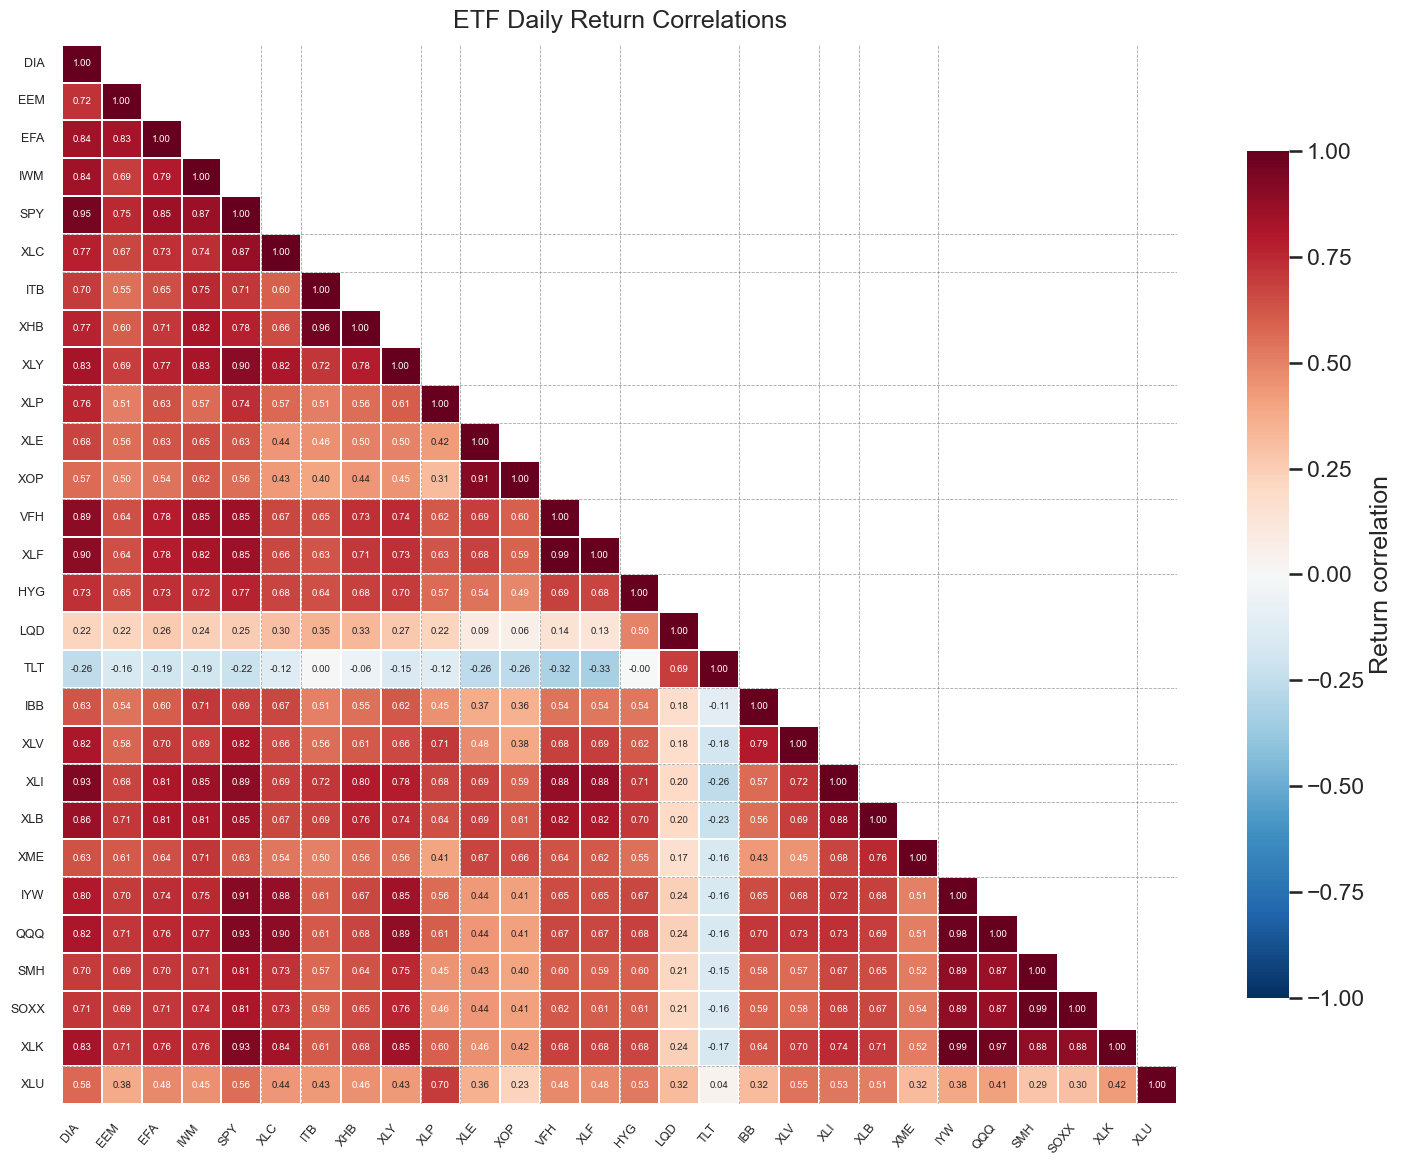

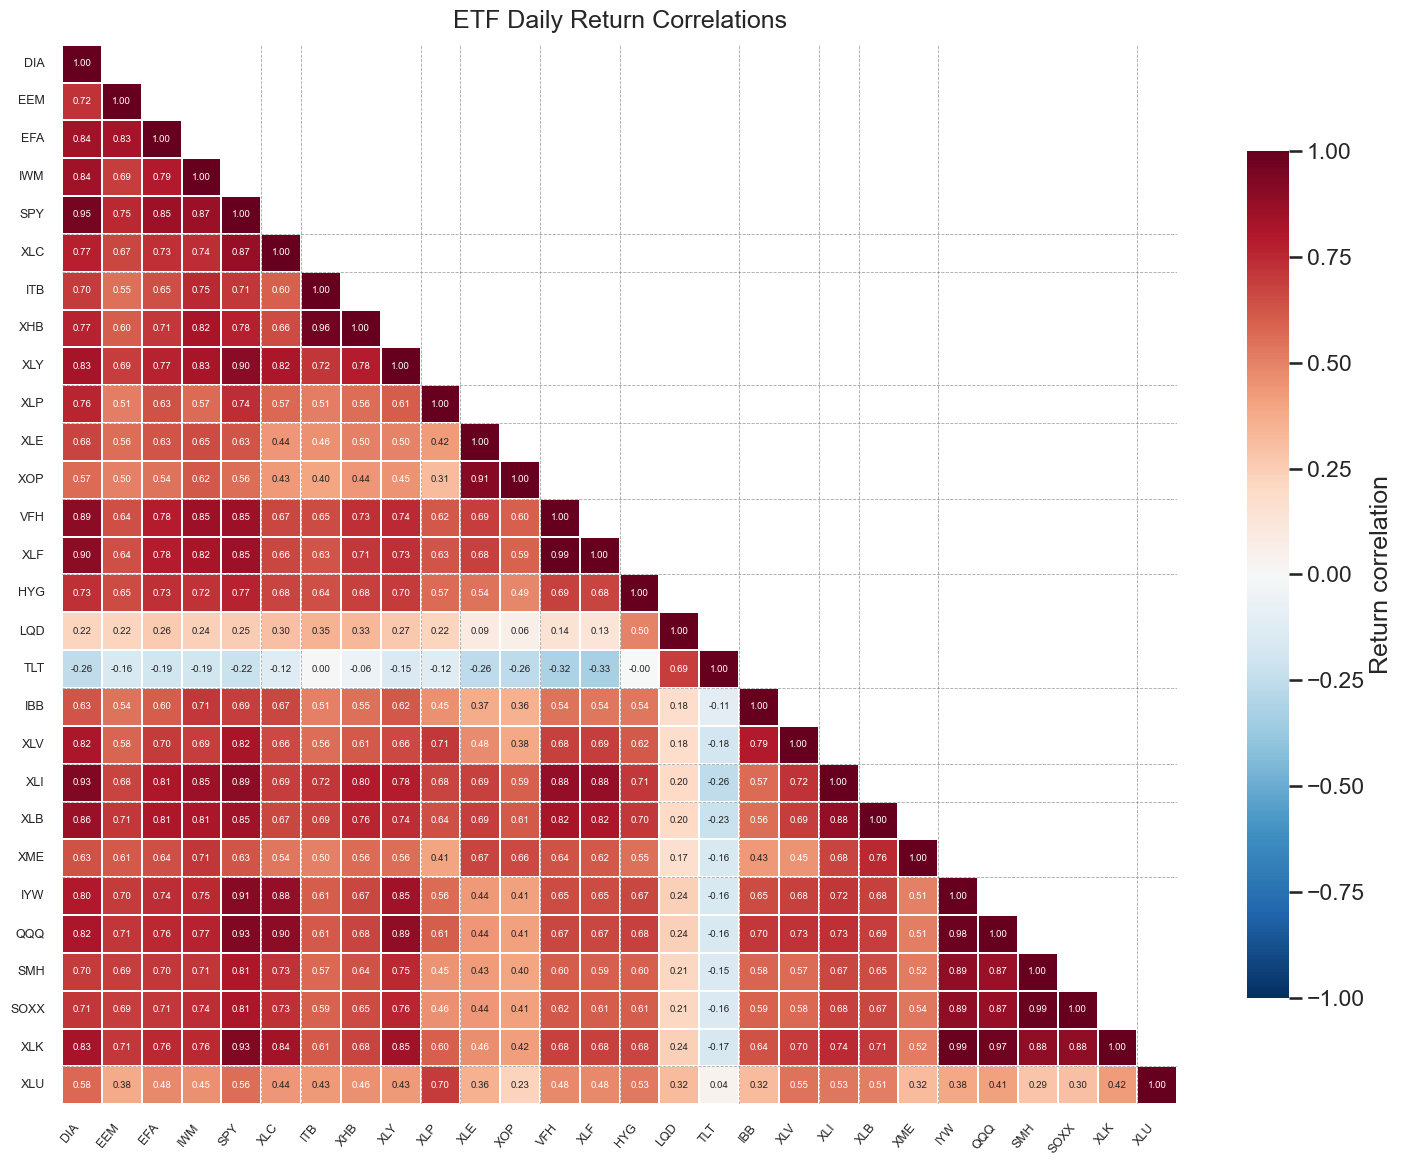

In [28]:
heatmap_fig = plot_correlation_heatmap(
    corr_matrix,
    lower_triangle=True,
    mask_diagonal=False,
    annot=True,
    figsize=(15, 12),
    output_path=HEATMAP_PATH,
    cmap="RdBu_r",
    metadata=metadata_df,
)
print(f"Saved correlation heatmap to {HEATMAP_PATH}")
heatmap_fig


Saved clustermap to i:\Winter-Break-Research\results\figures\week1\week1_corr_clustermap.png


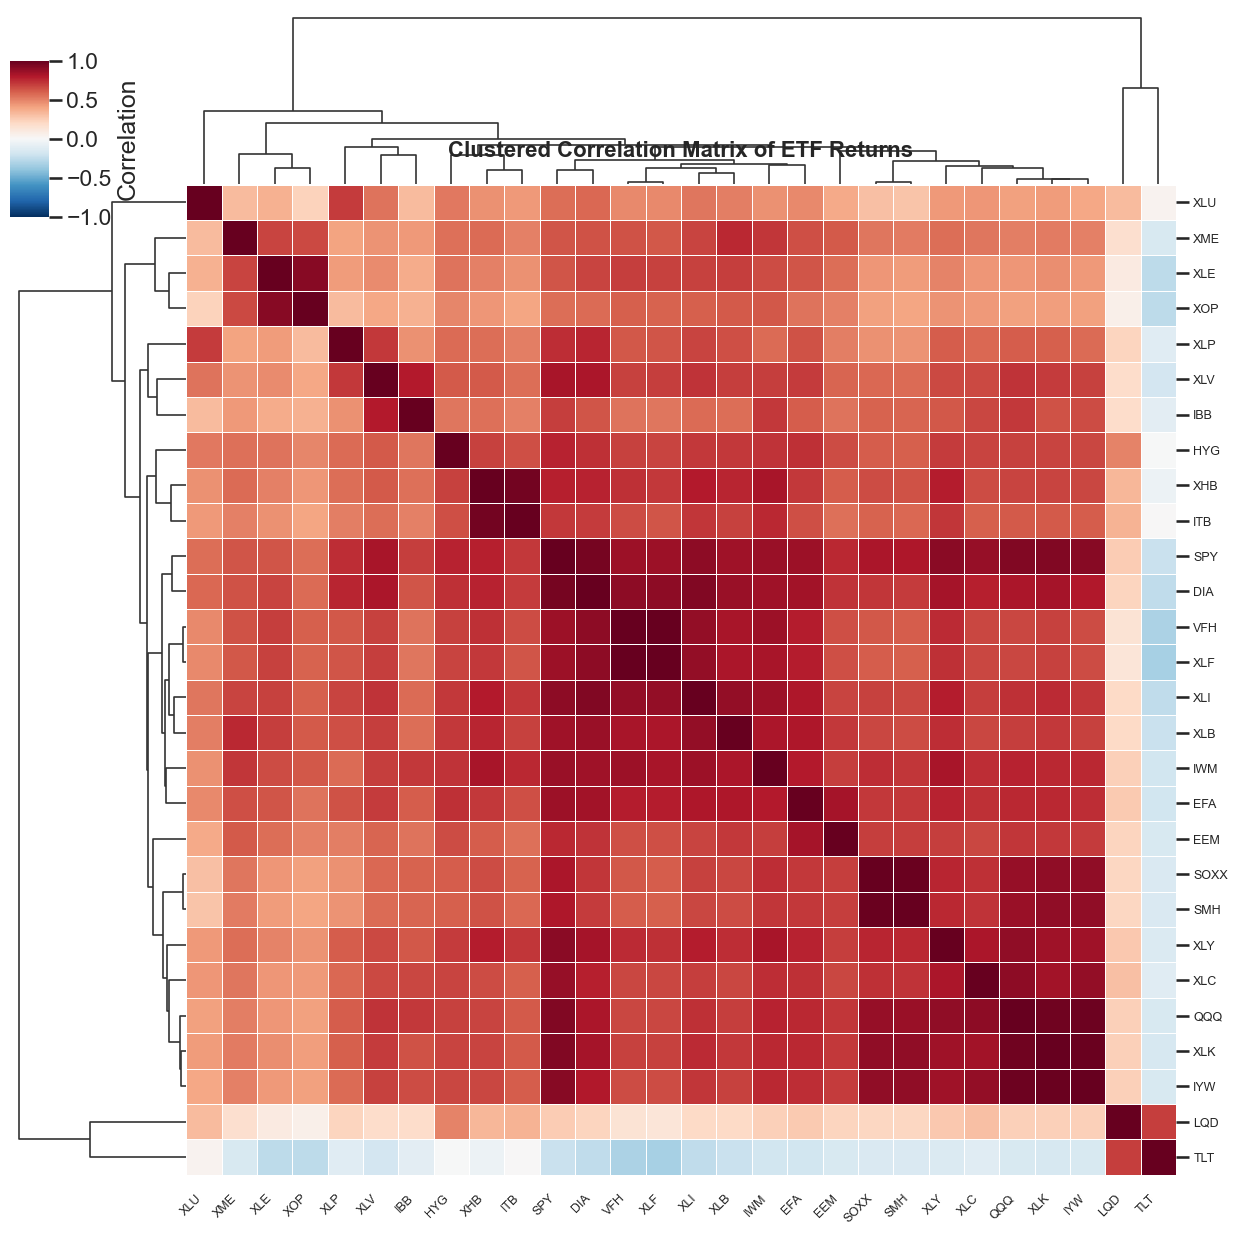

In [29]:
cluster_grid = plot_correlation_clustermap(
    corr_matrix,
    output_path=CLUSTER_PATH,
)
print(f"Saved clustermap to {CLUSTER_PATH}")
cluster_grid


## High-Correlation Pair Search
Iteratively back off the minimum correlation threshold until we surface at least one qualifying pair and persist the ranked table.

In [30]:
base_corr_threshold = pair_defaults.get("min_corr", 0.85)
backoff_steps = (0.0, 0.02, 0.05, 0.08, 0.12, 0.15)
corr_trials = []
high_corr_pairs = pd.DataFrame()
selected_threshold = None

for step in backoff_steps:
    trial_threshold = round(max(base_corr_threshold - step, 0.7), 3)
    if corr_trials and abs(trial_threshold - corr_trials[-1]["threshold"]) < 1e-6:
        continue
    trial_df = find_high_corr_pairs(corr_matrix, threshold=trial_threshold)
    corr_trials.append({"threshold": trial_threshold, "pair_count": len(trial_df)})
    if not trial_df.empty:
        high_corr_pairs = trial_df.assign(corr_threshold_used=trial_threshold)
        selected_threshold = trial_threshold
        break

attempt_log = pd.DataFrame(corr_trials)
print("High-correlation pair search attempts:")
display(attempt_log)

if high_corr_pairs.empty:
    print(
        "No correlation pairs cleared the adaptive thresholds; consider expanding the lookback window or lowering min_corr further.",
    )
else:
    metadata_source = metadata_df if not metadata_df.empty else (universe.metadata or {})
    high_corr_pairs = attach_sector_labels(high_corr_pairs, metadata_source)
    high_corr_pairs.to_csv(HIGH_CORR_PATH, index=False)
    print(
        f"Full high-correlation pair table saved to {HIGH_CORR_PATH} using threshold {selected_threshold:.2f}",
    )
    display(high_corr_pairs.sort_values("correlation", ascending=False).head(10))

High-correlation pair search attempts:


,threshold,pair_count
0,0.85,36


Full high-correlation pair table saved to i:\Winter-Break-Research\results\week1_high_corr_pairs.csv using threshold 0.85


,leg_x,leg_y,correlation,pair_bucket,corr_threshold_used,sector_x,sector_y
0,VFH,XLF,0.993432,Same Sector,0.85,Financials,Financials
1,SOXX,SMH,0.989518,Same Sector,0.85,Technology,Technology
2,XLK,IYW,0.987665,Same Sector,0.85,Technology,Technology
3,QQQ,IYW,0.983171,Same Sector,0.85,Technology,Technology
4,QQQ,XLK,0.973701,Same Sector,0.85,Technology,Technology
5,XHB,ITB,0.962823,Same Sector,0.85,Consumer Discretionary,Consumer Discretionary
6,SPY,DIA,0.954205,Same Sector,0.85,Broad Market,Broad Market
7,DIA,XLI,0.929359,Cross Sector,0.85,Broad Market,Industrials
8,SPY,QQQ,0.929155,Cross Sector,0.85,Broad Market,Technology
9,SPY,XLK,0.928009,Cross Sector,0.85,Broad Market,Technology


In [31]:
def run_pair_scan_with_backoff(
    cfg: PairScanConfig,
    *,
    corr_thresholds: list[float] | None = None,
 ) -> tuple[pd.DataFrame, list[dict[str, float]]]:
    """Run the pair scan across a list of correlation thresholds until we get results."""
    thresholds = corr_thresholds or [cfg.min_corr]
    attempt_log: list[dict[str, float]] = []
    for thr in thresholds:
        trial_cfg = replace(cfg, min_corr=thr)
        trial_df = run_pair_scan(trial_cfg)
        attempt_log.append({"min_corr": thr, "pair_count": len(trial_df)})
        if not trial_df.empty:
            trial_df = trial_df.copy()
            trial_df["min_corr_used"] = thr
            return trial_df, attempt_log
    return pd.DataFrame(), attempt_log

## Pipeline Backoff Runner
Execute the production pair-scan pipeline with adaptive correlation thresholds and persist scored pairs for Track A reporting.

In [32]:
pair_cfg_kwargs = {
    "config_path": CONFIG_PATH,
    "price_path": PRICE_PATH,
    "output_path": RESULTS_PATH,
    "list_name": LIST_OVERRIDE,
    "metadata_path": METADATA_PATH,
    "lookback_days": pair_defaults.get("lookback_days", 252),
    "min_obs": pair_defaults.get("min_obs", 150),
    "min_corr": pair_defaults.get("min_corr", 0.85),
    "max_pairs": pair_defaults.get("max_pairs", 50),
    "engle_granger_maxlag": pair_defaults.get("engle_granger_maxlag", 1),
    "return_method": pair_defaults.get("return_method", "log"),
}
if "allow_cross_sector" in inspect.signature(PairScanConfig).parameters:
    pair_cfg_kwargs["allow_cross_sector"] = ALLOW_CROSS_SECTOR

pair_scan_cfg = PairScanConfig(**pair_cfg_kwargs)

corr_backoff = []
for step in (0.0, 0.02, 0.04, 0.07, 0.1, 0.12, 0.15):
    candidate = round(max(pair_scan_cfg.min_corr - step, 0.7), 3)
    if not corr_backoff or candidate != corr_backoff[-1]:
        corr_backoff.append(candidate)

pair_scores, scan_attempts = run_pair_scan_with_backoff(
    pair_scan_cfg, corr_thresholds=corr_backoff
 )
print("Pair-scan attempts by min_corr:")
display(pd.DataFrame(scan_attempts))

if pair_scores.empty:
    print("No pairs met the scan criteria even after backoff; inspect coverage stats or relax parameters further.")
else:
    pair_scores.to_csv(RESULTS_PATH, index=False)
    print(f"Scored {len(pair_scores)} pairs using min_corr >= {pair_scores['min_corr_used'].iloc[0]:.2f}.")
    print(
        f"Pair score snapshot saved to {RESULTS_PATH} (cross-sector allowed: {ALLOW_CROSS_SECTOR})",
    )
    display(pair_scores.head())

Pair-scan attempts by min_corr:


,min_corr,pair_count
0,0.85,17


Scored 17 pairs using min_corr >= 0.85.
Pair score snapshot saved to i:\Winter-Break-Research\results\week1_pair_scores.csv (cross-sector allowed: True)


,universe,leg_x,leg_y,correlation,n_obs,spread_mean,spread_std,hedge_ratio,coint_statistic,coint_pvalue,half_life,min_corr_used
0,core_sectors,IYW,QQQ,0.975977,251,-23.701377,1.030432,0.361718,-3.435427,0.038565,4566.442823,0.85
1,core_sectors,XLK,IYW,0.982243,251,47.708402,1.884291,1.165181,-3.076177,0.093189,3867.729233,0.85
2,core_sectors,XLK,SPY,0.901638,251,27.374242,4.789980,0.351427,-3.070396,0.094405,505.315941,0.85
3,core_sectors,XLK,QQQ,0.964501,251,20.801650,2.531455,0.419930,-3.018295,0.105921,538.203975,0.85
4,core_sectors,XLF,VFH,0.985795,251,2.139444,0.169182,0.391577,-2.909426,0.133334,NaN,0.85


In [33]:
if pair_scores.empty:
    print("No qualifying pairs found; adjust thresholds and rerun.")
else:
    metadata_source = metadata_df if not metadata_df.empty else (universe.metadata or {})
    pair_scores = attach_sector_labels(pair_scores, metadata_source)

    corr_summary = summarise_pairs_by_bucket(pair_scores)
    display(corr_summary)
    corr_path = RESULTS_PATH.parent / "week1_pair_corr_summary.csv"
    corr_summary.to_csv(corr_path)
    print(f"Correlation summary saved to {corr_path}")

    pvalue_summary = (
        pair_scores.groupby("pair_bucket")["coint_pvalue"].agg(["mean", "median"]).round(4)
    )
    display(pvalue_summary)
    pval_path = RESULTS_PATH.parent / "week1_pair_pvalues_summary.csv"
    pvalue_summary.to_csv(pval_path)
    print(f"Engle–Granger p-value summary saved to {pval_path}")


,n_pairs,mean,min,max
pair_bucket,,,,
Cross Sector,3,0.919,0.902,0.945
Same Sector,14,0.935,0.883,0.986


Correlation summary saved to i:\Winter-Break-Research\results\week1_pair_corr_summary.csv


,mean,median
pair_bucket,,
Cross Sector,0.2570,0.2498
Same Sector,0.6528,0.8362


Engle–Granger p-value summary saved to i:\Winter-Break-Research\results\week1_pair_pvalues_summary.csv


Saved count plot to i:\Winter-Break-Research\results\figures\week1\week1_pair_bucket_counts.png


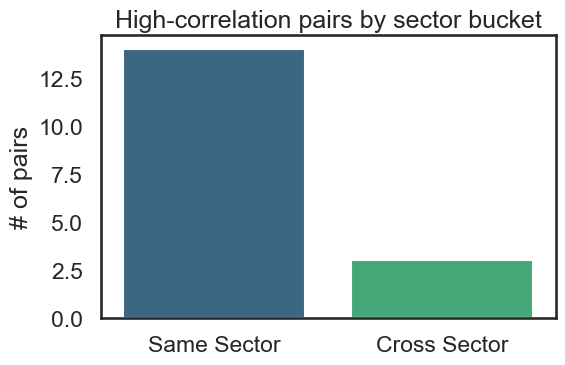

In [40]:
if pair_scores.empty:
    print("Skipping count plot because no pairs were scored.")
else:
    count_fig = plot_pair_bucket_counts(pair_scores, output_path=PAIR_COUNTS_PATH)
    print(f"Saved count plot to {PAIR_COUNTS_PATH}")
    count_fig


Saved correlation boxplot to i:\Winter-Break-Research\results\figures\week1\week1_pair_corr_box.png


i:\Winter-Break-Research\src\pairs_trading_etf\visualization\plots.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pairs_df, x="pair_bucket", y="correlation", palette="pastel", ax=ax)


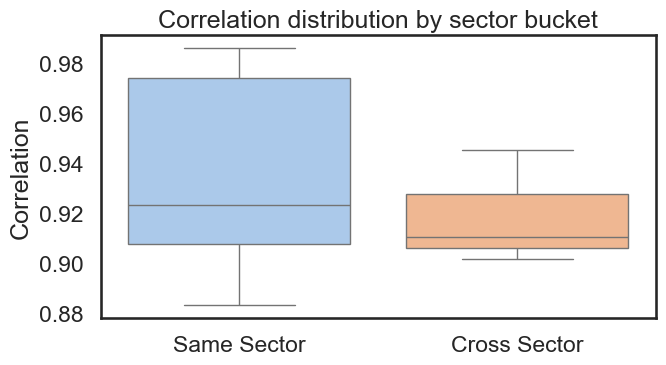

In [35]:
if pair_scores.empty:
    print("Skipping boxplot because no pairs were scored.")
else:
    box_fig = plot_pair_bucket_boxplot(pair_scores, output_path=PAIR_BOX_PATH)
    print(f"Saved correlation boxplot to {PAIR_BOX_PATH}")
    box_fig


Saved scatter plot to i:\Winter-Break-Research\results\figures\week1\week1_corr_vs_pvalue.png


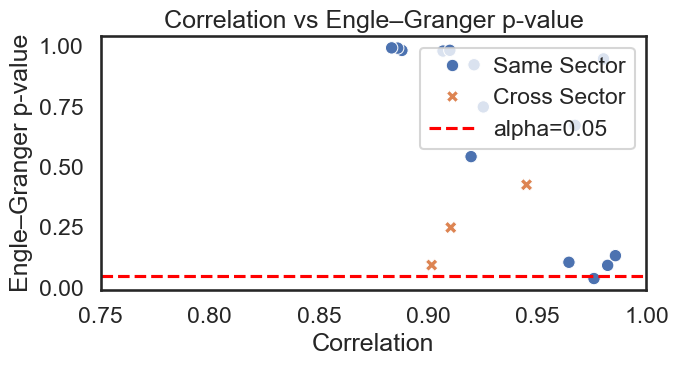

In [36]:
if pair_scores.empty:
    print("Skipping scatter plot because no pairs were scored.")
else:
    try:
        scatter_fig = plot_corr_vs_pvalue(pair_scores, output_path=SCATTER_PATH)
    except ValueError as exc:
        print(f"Skipping scatter plot: {exc}")
    else:
        print(f"Saved scatter plot to {SCATTER_PATH}")
        scatter_fig


## Johansen Confirmation
Validate the strongest trio with the Johansen trace test and archive the statistic table for Track C documentation.

In [37]:
if pair_scores.empty:
    print("Skipping Johansen test because no pairs were scored.")
else:
    top_pairs = pair_scores.sort_values("correlation", ascending=False).head(3)
    candidate = []
    for _, row in top_pairs.iterrows():
        for leg in (row["leg_x"], row["leg_y"]):
            if leg not in candidate:
                candidate.append(leg)
        if len(candidate) >= 3:
            break

    if len(candidate) < 3:
        print(
            "Need at least three unique tickers from the scored pairs to run the Johansen test."
        )
    else:
        price_frame = build_price_frame(
            PRICE_PATH, tickers=candidate, min_non_na=150, return_method="log"
        )
        levels = price_frame.prices[candidate].dropna()
        log_levels = np.log(levels.where(levels > 0)).dropna()

        johansen_res = coint_johansen(log_levels, det_order=0, k_ar_diff=1)
        trace_df = pd.DataFrame(
            {
                "trace_stat": johansen_res.lr1,
                "crit_90": johansen_res.cvt[:, 0],
                "crit_95": johansen_res.cvt[:, 1],
                "crit_99": johansen_res.cvt[:, 2],
            },
            index=[f"r <= {i}" for i in range(len(johansen_res.lr1))],
        )

        print(f"Johansen trace test for candidate set: {', '.join(candidate[:3])}")
        display(trace_df.round(3))
        trace_df.to_csv(JOHANSEN_PATH)
        print(f"Johansen trace table saved to {JOHANSEN_PATH}")

Johansen trace test for candidate set: XLF, VFH, XLK


,trace_stat,crit_90,crit_95,crit_99
r <= 0,38.492,44.493,47.854,54.682
r <= 1,15.255,27.067,29.796,35.463
r <= 2,4.228,13.429,15.494,19.935
r <= 3,0.592,2.706,3.842,6.635


Johansen trace table saved to i:\Winter-Break-Research\results\week1_johansen_trace.csv


## Week 1 pair-scan outputs
- `results/week1_pair_scores.csv` is overwritten on each run with the latest ranked pairs.
- `results/week1_pair_corr_summary.csv` and `results/week1_pair_pvalues_summary.csv` capture the bucketed stats for downstream reporting.
- Static figures (`results/figures/week1/*.png`) include the pair-bucket count bar, correlation boxplot, and correlation vs Engle–Granger scatter to drop into advisor decks.
- `results/week1_johansen_trace.csv` stores the Johansen trace table for the top trio, aligning with the Track C deliverables.
- Re-run the notebook whenever `configs/data.yaml` changes to regenerate all artifacts with the updated universe.